In [1]:
import pandas
import os
import string
import itertools
from biotite.sequence.phylo import upgma
from matplotlib import pyplot
from io import StringIO
from Bio import Phylo

In [2]:
data_path = "../../../data"

In [3]:
df = pandas.read_csv(f"{data_path}/final_cluster.csv")

In [4]:
df.describe()

,Right,Total
count,60.000000,60.0
mean,13.600000,14.0
std,1.330222,0.0
min,4.000000,14.0
25%,13.750000,14.0
50%,14.000000,14.0
75%,14.000000,14.0
max,14.000000,14.0


In [5]:
df.sort_values(by="Right").head(30)

,Name,Family,Right,Total
11,pan_paniscus_ENSPPAG00000043476.png,orthologs_cytoglobin,4,14
55,mandrillus_leucophaeus_ENSMLEG00000035424.png,orthologs_neuroglobin,13,14
56,carlito_syrichta_ENSTSYG00000026821.png,orthologs_neuroglobin,13,14
13,cebus_capucinus_ENSCCAG00000037088.png,orthologs_cytoglobin,13,14
12,mandrillus_leucophaeus_ENSMLEG00000043678.png,orthologs_cytoglobin,13,14
10,rhinopithecus_bieti_ENSRBIG00000040278.png,orthologs_cytoglobin,13,14
8,rhinopithecus_roxellana_ENSRROG00000038611.png,orthologs_cytoglobin,13,14
0,homo_sapiens_ENSG00000161544.png,orthologs_cytoglobin,13,14
6,nomascus_leucogenys_ENSNLEG00000002476.png,orthologs_cytoglobin,13,14
5,prolemur_simus_ENSPSMG00000023947.png,orthologs_cytoglobin,13,14


In [6]:
df[df["Right"] == df["Total"]].Name.size / df.Name.size

0.75

In [7]:
with open(f"{data_path}/cluster_sim.txt") as f:
    sim_hash = eval(f.read())

In [8]:
df_all = pandas.DataFrame.from_dict(sim_hash)
df_all.columns = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.columns]
df_all.index = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.index]

In [9]:
fixed_df_all = df_all.sort_index()[sorted(df_all.columns)]
numpy_all = fixed_df_all.to_numpy(na_value=0)

In [10]:
def color_clade(clade):
    green_pallete = [
        "darkolivegreen",
        "turquoise",
        "forestgreen",
        "green",
        "darkcyan",
        "teal",
        "mediumaquamarine",
        "seagreen",
        "limegreen",
        "mediumseagreen",
        "mediumspringgreen"]
    clade_colors = {
        "androglobin": "red",
        "cytoglobin": "orange",
        "neuroglobin": "blue",
        "myoglobin": "brown",
        "hemoglobin": "purple",
        "indelible": green_pallete
    }
    for name, color in clade_colors.items():
            if name in clade:
                return color if type(color) == str else color[int(clade[-1])]



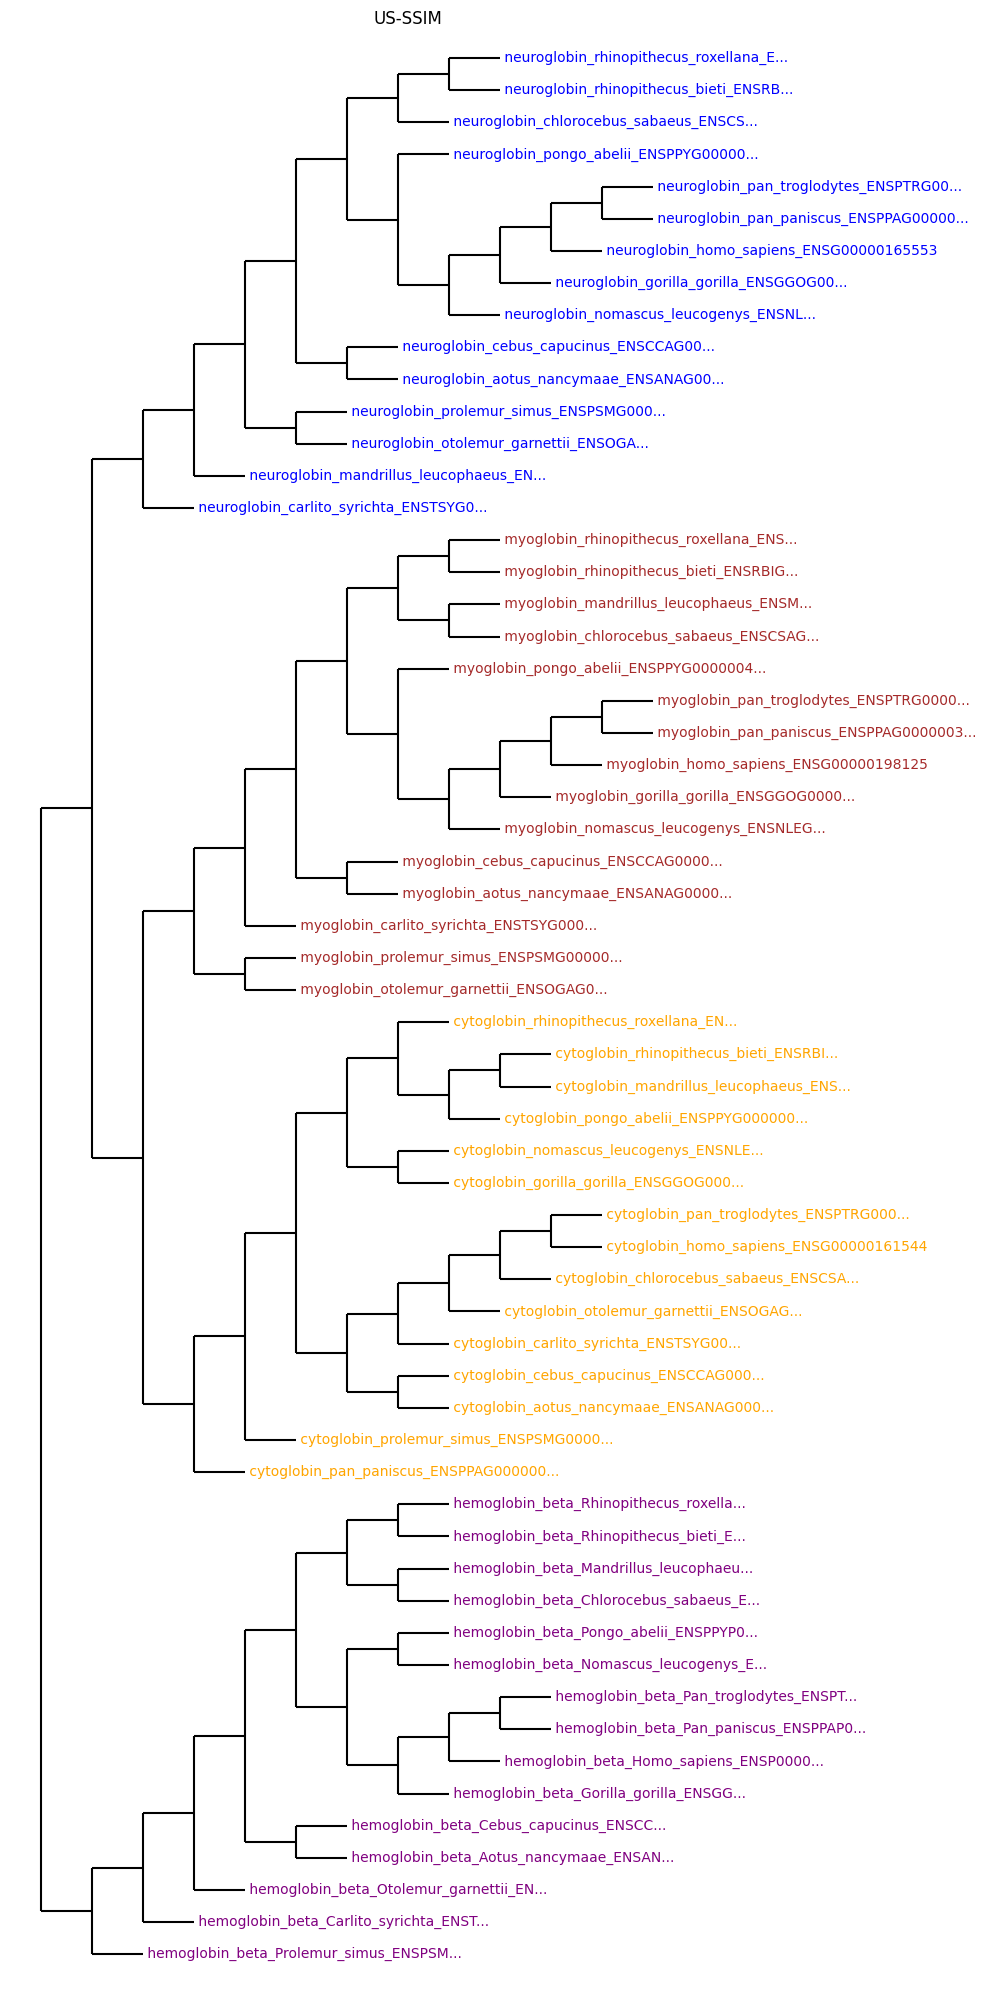

In [11]:
tree = upgma(abs(1.0-numpy_all))

fig, ax = pyplot.subplots(1, 1, figsize=(10, 20), layout="constrained")
newick = tree.to_newick(labels=list(fixed_df_all.columns), include_distance=False)
newick = tree.to_newick(labels=["_".join(i.replace("-", "_").split("_")[1:]) for i in list(fixed_df_all.columns)], include_distance=False)
with open(f"{data_path}/blast/db_blast US-SSIM.nw", "w") as f:
    f.write(newick)
t = Phylo.read(StringIO(newick), "newick")
#     t.ladderize()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("US-SSIM")
ax.axis('off')
Phylo.draw(
    t,
    show_confidence=False,
    axes=ax,
    do_show=False,
    label_colors=color_clade,
    branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(
        clade.confidence) if clade.confidence else ""
)
pyplot.xlabel("")
pyplot.ylabel("")
pyplot.tight_layout()
pyplot.show()

In [12]:
fixed_df_all.head()

,orthologs_cytoglobin_aotus_nancymaae_ENSANAG00000037374,orthologs_cytoglobin_carlito_syrichta_ENSTSYG00000029754,orthologs_cytoglobin_cebus_capucinus_ENSCCAG00000037088,orthologs_cytoglobin_chlorocebus_sabaeus_ENSCSAG00000005082,orthologs_cytoglobin_gorilla_gorilla_ENSGGOG00000001385,orthologs_cytoglobin_homo_sapiens_ENSG00000161544,orthologs_cytoglobin_mandrillus_leucophaeus_ENSMLEG00000043678,orthologs_cytoglobin_nomascus_leucogenys_ENSNLEG00000002476,orthologs_cytoglobin_otolemur_garnettii_ENSOGAG00000034659,orthologs_cytoglobin_pan_paniscus_ENSPPAG00000043476,...,orthologs_neuroglobin_homo_sapiens_ENSG00000165553,orthologs_neuroglobin_mandrillus_leucophaeus_ENSMLEG00000035424,orthologs_neuroglobin_nomascus_leucogenys_ENSNLEG00000016682,orthologs_neuroglobin_otolemur_garnettii_ENSOGAG00000006194,orthologs_neuroglobin_pan_paniscus_ENSPPAG00000040520,orthologs_neuroglobin_pan_troglodytes_ENSPTRG00000006575,orthologs_neuroglobin_pongo_abelii_ENSPPYG00000006019,orthologs_neuroglobin_prolemur_simus_ENSPSMG00000011006,orthologs_neuroglobin_rhinopithecus_bieti_ENSRBIG00000038926,orthologs_neuroglobin_rhinopithecus_roxellana_ENSRROG00000044996
orthologs_cytoglobin_aotus_nancymaae_ENSANAG00000037374,NaN,0.291853,0.698417,0.502711,0.391048,0.505198,0.414027,0.396200,0.471599,0.119487,...,0.144990,0.138345,0.144675,0.141910,0.143262,0.143262,0.143736,0.160290,0.144356,0.144356
orthologs_cytoglobin_carlito_syrichta_ENSTSYG00000029754,0.291853,NaN,0.276079,0.819912,0.265045,0.800105,0.283402,0.268542,0.799017,0.253384,...,0.127877,0.115793,0.127270,0.126669,0.126611,0.126611,0.126942,0.143261,0.127944,0.127944
orthologs_cytoglobin_cebus_capucinus_ENSCCAG00000037088,0.698417,0.276079,NaN,0.445117,0.434932,0.460374,0.457195,0.430590,0.436473,0.139739,...,0.135115,0.134882,0.135175,0.131637,0.133138,0.133138,0.134377,0.149650,0.134116,0.134116
orthologs_cytoglobin_chlorocebus_sabaeus_ENSCSAG00000005082,0.502711,0.819912,0.445117,NaN,0.482604,0.936179,0.500723,0.468290,0.812628,0.121935,...,0.136787,0.135719,0.137274,0.136999,0.135307,0.135307,0.137574,0.151183,0.134380,0.134380
orthologs_cytoglobin_gorilla_gorilla_ENSGGOG00000001385,0.391048,0.265045,0.434932,0.482604,NaN,0.506166,0.417011,0.881429,0.445473,0.111686,...,0.140239,0.137207,0.139309,0.133497,0.138505,0.138505,0.140197,0.145639,0.137792,0.137792


In [13]:
by_homologues = {}
only_homologues = {}
for column in fixed_df_all.columns:
    name = column.split("_")[0] if len(column.split("_")) == 2 else column.split("_")[1]
    k = 40 if len(column.split("_")) == 2 else 14
    if name in by_homologues:
        by_homologues[name] += list(fixed_df_all[column].sort_values(ascending=False).index[:k])
        only_homologues[name] += [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]
    else:
        by_homologues[name] = list(fixed_df_all[column].sort_values(ascending=False).index[:k])
        only_homologues[name] = [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]
#Precision, MAP
print(f"--------US-SSIM--------")
for h in only_homologues:
    print(h)
    print("Precision:", sum([i==h for i in only_homologues[h]])/len(only_homologues[h]))
    precision = [0]
    p_k = 0
    for i in only_homologues[h]:
        precision.append((i==h)+precision[-1])
    for k in range(1,len(precision)):
        p_k += precision[k]/k
    print("Mean Average Precision", p_k/len(only_homologues[h]))
    print("-------------------------------------------------")

--------US-SSIM--------
cytoglobin
Precision: 0.8952380952380953
Mean Average Precision 0.9300775605226149
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.9904761904761905
Mean Average Precision 0.986643450773519
-------------------------------------------------


In [14]:
fixed_df_all.describe()

,orthologs_cytoglobin_aotus_nancymaae_ENSANAG00000037374,orthologs_cytoglobin_carlito_syrichta_ENSTSYG00000029754,orthologs_cytoglobin_cebus_capucinus_ENSCCAG00000037088,orthologs_cytoglobin_chlorocebus_sabaeus_ENSCSAG00000005082,orthologs_cytoglobin_gorilla_gorilla_ENSGGOG00000001385,orthologs_cytoglobin_homo_sapiens_ENSG00000161544,orthologs_cytoglobin_mandrillus_leucophaeus_ENSMLEG00000043678,orthologs_cytoglobin_nomascus_leucogenys_ENSNLEG00000002476,orthologs_cytoglobin_otolemur_garnettii_ENSOGAG00000034659,orthologs_cytoglobin_pan_paniscus_ENSPPAG00000043476,...,orthologs_neuroglobin_homo_sapiens_ENSG00000165553,orthologs_neuroglobin_mandrillus_leucophaeus_ENSMLEG00000035424,orthologs_neuroglobin_nomascus_leucogenys_ENSNLEG00000016682,orthologs_neuroglobin_otolemur_garnettii_ENSOGAG00000006194,orthologs_neuroglobin_pan_paniscus_ENSPPAG00000040520,orthologs_neuroglobin_pan_troglodytes_ENSPTRG00000006575,orthologs_neuroglobin_pongo_abelii_ENSPPYG00000006019,orthologs_neuroglobin_prolemur_simus_ENSPSMG00000011006,orthologs_neuroglobin_rhinopithecus_bieti_ENSRBIG00000038926,orthologs_neuroglobin_rhinopithecus_roxellana_ENSRROG00000044996
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.206111,0.192244,0.199458,0.240619,0.210129,0.243029,0.204816,0.209514,0.225143,0.132236,...,0.280134,0.238844,0.279455,0.253111,0.277724,0.277724,0.272067,0.266750,0.272745,0.272745
std,0.139958,0.177092,0.140865,0.213217,0.160409,0.217054,0.148400,0.153977,0.197426,0.038651,...,0.332596,0.248652,0.330824,0.283331,0.330509,0.330509,0.319263,0.293364,0.319329,0.319329
min,0.113147,0.100157,0.106148,0.116910,0.106519,0.116821,0.105840,0.108775,0.110802,0.107995,...,0.069951,0.071129,0.069765,0.063388,0.068711,0.068711,0.070116,0.068988,0.067929,0.067929
25%,0.121989,0.113494,0.119383,0.124738,0.121993,0.125992,0.122039,0.121884,0.119212,0.119629,...,0.082962,0.082273,0.082929,0.081985,0.081979,0.081979,0.080610,0.088180,0.082094,0.082094
50%,0.144356,0.127270,0.135175,0.137574,0.139668,0.138026,0.137802,0.141325,0.132107,0.125436,...,0.110930,0.123166,0.114334,0.114193,0.108769,0.108769,0.111675,0.128885,0.113425,0.113425
75%,0.164487,0.143406,0.153224,0.172053,0.153953,0.173320,0.153966,0.160753,0.160815,0.131983,...,0.144122,0.138447,0.143690,0.140278,0.142625,0.142625,0.143473,0.156143,0.142867,0.142867
max,0.698417,0.819912,0.698417,0.936179,0.881429,0.986519,0.741020,0.881429,0.842442,0.387833,...,0.990888,0.774607,0.974431,0.847132,1.000000,1.000000,0.944205,0.847132,1.000000,1.000000


In [15]:
dfs_control = {}
control_dir = os.path.join(data_path, "blast")
for f in os.listdir(control_dir):
    if f.endswith(".csv"):
        name = f.split(".")[0]
        dfs_control[name] = pandas.read_csv(os.path.join(control_dir, f))

In [16]:
for dataset, df_control in dfs_control.items():
    k=15 if "orthologs" in dataset else 40
    name = (dataset.replace("orthologs_", ""),) if "orthologs" in dataset else list(map("".join, itertools.product("ABCD", string.digits)))
    print(dataset)
    results = dfs_control[dataset].groupby("qseqid").head(k).groupby("qseqid").apply(
        lambda x: x["sseqid"].str.split("-", expand = True)[0].isin(name))
    # Precision
    print(results.sum() / results.count())
    display(df_control.groupby("qseqid").head(k).pivot(index="qseqid", columns="sseqid", values="bitscore"))

orthologs_cytoglobin
1.0


sseqid,cytoglobin-aotus_nancymaae_ENSANAG00000037374,cytoglobin-carlito_syrichta_ENSTSYG00000029754,cytoglobin-cebus_capucinus_ENSCCAG00000037088,cytoglobin-chlorocebus_sabaeus_ENSCSAG00000005082,cytoglobin-gorilla_gorilla_ENSGGOG00000001385,cytoglobin-homo_sapiens_ENSG00000161544,cytoglobin-mandrillus_leucophaeus_ENSMLEG00000043678,cytoglobin-nomascus_leucogenys_ENSNLEG00000002476,cytoglobin-otolemur_garnettii_ENSOGAG00000034659,cytoglobin-pan_paniscus_ENSPPAG00000043476,cytoglobin-pan_troglodytes_ENSPTRG00000033861,cytoglobin-pongo_abelii_ENSPPYG00000008661,cytoglobin-prolemur_simus_ENSPSMG00000023947,cytoglobin-rhinopithecus_bieti_ENSRBIG00000040278,cytoglobin-rhinopithecus_roxellana_ENSRROG00000038611
qseqid,,,,,,,,,,,,,,,
aotus_nancymaae_ENSANAG00000037374,1158.0,244.0,806.0,627.0,632.0,638.0,636.0,621.0,599.0,579.0,632.0,651.0,638.0,628.0,634.0
carlito_syrichta_ENSTSYG00000029754,244.0,699.0,237.0,593.0,250.0,582.0,267.0,244.0,582.0,244.0,588.0,255.0,255.0,261.0,255.0
cebus_capucinus_ENSCCAG00000037088,806.0,237.0,1064.0,592.0,603.0,608.0,621.0,592.0,582.0,542.0,603.0,603.0,592.0,601.0,592.0
chlorocebus_sabaeus_ENSCSAG00000005082,627.0,593.0,592.0,1059.0,649.0,998.0,682.0,627.0,893.0,571.0,987.0,660.0,621.0,676.0,682.0
gorilla_gorilla_ENSGGOG00000001385,632.0,250.0,603.0,649.0,1142.0,688.0,649.0,1020.0,599.0,610.0,682.0,676.0,630.0,654.0,953.0
homo_sapiens_ENSG00000161544,638.0,582.0,608.0,998.0,688.0,1059.0,649.0,643.0,915.0,616.0,1048.0,676.0,621.0,654.0,660.0
mandrillus_leucophaeus_ENSMLEG00000043678,636.0,267.0,621.0,682.0,649.0,649.0,1147.0,627.0,582.0,734.0,643.0,822.0,621.0,961.0,758.0
nomascus_leucogenys_ENSNLEG00000002476,621.0,244.0,592.0,627.0,1020.0,643.0,627.0,1142.0,571.0,571.0,638.0,660.0,625.0,621.0,915.0
otolemur_garnettii_ENSOGAG00000034659,599.0,582.0,582.0,893.0,599.0,915.0,582.0,571.0,1059.0,527.0,915.0,593.0,610.0,599.0,593.0


orthologs_androglobin
1.0


sseqid,androglobin-aotus_nancymaae_ENSANAG00000025329,androglobin-carlito_syrichta_ENSTSYG00000002644,androglobin-cebus_capucinus_ENSCCAG00000032521,androglobin-chlorocebus_sabaeus_ENSCSAG00000017175,androglobin-gorilla_gorilla_ENSGGOG00000001069,androglobin-homo_sapiens_ENSG00000118492,androglobin-mandrillus_leucophaeus_ENSMLEG00000042349,androglobin-nomascus_leucogenys_ENSNLEG00000015247,androglobin-otolemur_garnettii_ENSOGAG00000024602,androglobin-pan_paniscus_ENSPPAG00000031064,androglobin-pan_troglodytes_ENSPTRG00000018686,androglobin-pongo_abelii_ENSPPYG00000017077,androglobin-prolemur_simus_ENSPSMG00000018921,androglobin-rhinopithecus_bieti_ENSRBIG00000033722,androglobin-rhinopithecus_roxellana_ENSRROG00000037836
qseqid,,,,,,,,,,,,,,,
aotus_nancymaae_ENSANAG00000025329,9169.0,4337.0,7936.0,7239.0,7263.0,7564.0,7027.0,7356.0,1982.0,7515.0,7515.0,7424.0,2942.0,4394.0,7071.0
carlito_syrichta_ENSTSYG00000002644,4337.0,8754.0,4331.0,4397.0,4508.0,4525.0,4414.0,4479.0,1881.0,4475.0,4475.0,4473.0,2584.0,3177.0,4420.0
cebus_capucinus_ENSCCAG00000032521,7936.0,4331.0,8865.0,7070.0,7360.0,7420.0,7203.0,7310.0,1975.0,7369.0,7374.0,7337.0,2756.0,4196.0,7258.0
chlorocebus_sabaeus_ENSCSAG00000017175,7239.0,4397.0,7070.0,9103.0,7803.0,8139.0,8427.0,7956.0,1949.0,8117.0,8122.0,8046.0,2892.0,5208.0,8299.0
gorilla_gorilla_ENSGGOG00000001069,7263.0,4508.0,7360.0,7803.0,8898.0,8637.0,7908.0,8264.0,1982.0,8606.0,8600.0,8331.0,2778.0,4667.0,7980.0
homo_sapiens_ENSG00000118492,7564.0,4525.0,7420.0,8139.0,8637.0,9241.0,7947.0,8582.0,1999.0,8986.0,8970.0,8639.0,2987.0,5014.0,8041.0
mandrillus_leucophaeus_ENSMLEG00000042349,7027.0,4414.0,7203.0,8427.0,7908.0,7947.0,8898.0,7819.0,2004.0,7928.0,7923.0,7875.0,2693.0,4909.0,8421.0
nomascus_leucogenys_ENSNLEG00000015247,7356.0,4479.0,7310.0,7956.0,8264.0,8582.0,7819.0,9225.0,2010.0,8554.0,8549.0,8455.0,2948.0,4909.0,7897.0
otolemur_garnettii_ENSOGAG00000024602,1982.0,1881.0,1975.0,1949.0,1982.0,1999.0,2004.0,2010.0,3967.0,2004.0,2015.0,2032.0,1504.0,1808.0,2043.0


orthologs_hemoglobin_beta
1.0


sseqid,hemoglobin_beta-Aotus_nancymaae_ENSANAP00000000486_Anan,hemoglobin_beta-Carlito_syrichta_ENSTSYP00000007411_Csyr,hemoglobin_beta-Cebus_capucinus_ENSCCAP00000028244_Ccap,hemoglobin_beta-Chlorocebus_sabaeus_ENSCSAP00000000618_Csab,hemoglobin_beta-Gorilla_gorilla_ENSGGOP00000022371_Ggor,hemoglobin_beta-Homo_sapiens_ENSP00000333994_Hsap,hemoglobin_beta-Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu,hemoglobin_beta-Nomascus_leucogenys_ENSNLEP00000021062_Nleu,hemoglobin_beta-Otolemur_garnettii_ENSOGAP00000006779_Ogar,hemoglobin_beta-Pan_paniscus_ENSPPAP00000004625_Ppan,hemoglobin_beta-Pan_troglodytes_ENSPTRP00000005700_Ptro,hemoglobin_beta-Pongo_abelii_ENSPPYP00000004109_Pabe,hemoglobin_beta-Prolemur_simus_ENSPSMP00000000465_Psim,hemoglobin_beta-Rhinopithecus_bieti_ENSRBIP00000023384_Rbie,hemoglobin_beta-Rhinopithecus_roxellana_ENSRROP00000025038_Rrox
qseqid,,,,,,,,,,,,,,,
Aotus_nancymaae_ENSANAP00000000486_Anan,815.0,593.0,747.0,726.0,682.0,699.0,704.0,704.0,566.0,693.0,693.0,704.0,477.0,721.0,721.0
Carlito_syrichta_ENSTSYP00000007411_Csyr,593.0,815.0,575.0,555.0,549.0,555.0,532.0,566.0,555.0,549.0,549.0,577.0,472.0,560.0,571.0
Cebus_capucinus_ENSCCAP00000028244_Ccap,747.0,575.0,815.0,691.0,652.0,669.0,680.0,675.0,564.0,664.0,664.0,675.0,459.0,680.0,680.0
Chlorocebus_sabaeus_ENSCSAP00000000618_Csab,726.0,555.0,691.0,815.0,737.0,743.0,787.0,749.0,577.0,737.0,737.0,749.0,488.0,765.0,765.0
Gorilla_gorilla_ENSGGOP00000022371_Ggor,682.0,549.0,652.0,737.0,815.0,798.0,715.0,760.0,566.0,804.0,804.0,776.0,479.0,726.0,726.0
Homo_sapiens_ENSP00000333994_Hsap,699.0,555.0,669.0,743.0,798.0,815.0,721.0,765.0,571.0,809.0,809.0,771.0,472.0,743.0,743.0
Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu,704.0,532.0,680.0,787.0,715.0,721.0,815.0,721.0,577.0,715.0,715.0,721.0,488.0,737.0,737.0
Nomascus_leucogenys_ENSNLEP00000021062_Nleu,704.0,566.0,675.0,749.0,760.0,765.0,721.0,815.0,577.0,771.0,771.0,782.0,468.0,749.0,749.0
Otolemur_garnettii_ENSOGAP00000006779_Ogar,566.0,555.0,564.0,577.0,566.0,571.0,577.0,577.0,815.0,577.0,577.0,582.0,499.0,577.0,577.0


orthologs_myoglobin
1.0


sseqid,myoglobin-aotus_nancymaae_ENSANAG00000020373,myoglobin-carlito_syrichta_ENSTSYG00000026219,myoglobin-cebus_capucinus_ENSCCAG00000031738,myoglobin-chlorocebus_sabaeus_ENSCSAG00000008174,myoglobin-gorilla_gorilla_ENSGGOG00000011478,myoglobin-homo_sapiens_ENSG00000198125,myoglobin-mandrillus_leucophaeus_ENSMLEG00000032335,myoglobin-nomascus_leucogenys_ENSNLEG00000014375,myoglobin-otolemur_garnettii_ENSOGAG00000005651,myoglobin-pan_paniscus_ENSPPAG00000036732,myoglobin-pan_troglodytes_ENSPTRG00000023553,myoglobin-pongo_abelii_ENSPPYG00000040455,myoglobin-prolemur_simus_ENSPSMG00000021110,myoglobin-rhinopithecus_bieti_ENSRBIG00000040058,myoglobin-rhinopithecus_roxellana_ENSRROG00000020662
qseqid,,,,,,,,,,,,,,,
aotus_nancymaae_ENSANAG00000020373,859.0,584.0,776.0,671.0,660.0,643.0,643.0,654.0,497.0,649.0,649.0,649.0,580.0,643.0,632.0
carlito_syrichta_ENSTSYG00000026219,584.0,859.0,590.0,630.0,628.0,617.0,636.0,606.0,540.0,612.0,612.0,606.0,623.0,619.0,608.0
cebus_capucinus_ENSCCAG00000031738,776.0,590.0,859.0,682.0,665.0,649.0,654.0,660.0,503.0,643.0,643.0,654.0,603.0,643.0,632.0
chlorocebus_sabaeus_ENSCSAG00000008174,671.0,630.0,682.0,859.0,754.0,749.0,826.0,760.0,542.0,743.0,743.0,754.0,658.0,804.0,793.0
gorilla_gorilla_ENSGGOG00000011478,660.0,628.0,665.0,754.0,859.0,832.0,743.0,821.0,525.0,826.0,826.0,815.0,630.0,743.0,732.0
homo_sapiens_ENSG00000198125,643.0,617.0,649.0,749.0,832.0,859.0,737.0,826.0,531.0,832.0,832.0,798.0,619.0,737.0,726.0
mandrillus_leucophaeus_ENSMLEG00000032335,643.0,636.0,654.0,826.0,743.0,737.0,859.0,749.0,525.0,732.0,732.0,743.0,636.0,815.0,804.0
nomascus_leucogenys_ENSNLEG00000014375,654.0,606.0,660.0,760.0,821.0,826.0,749.0,859.0,542.0,821.0,821.0,798.0,625.0,760.0,749.0
otolemur_garnettii_ENSOGAG00000005651,497.0,540.0,503.0,542.0,525.0,531.0,525.0,542.0,859.0,520.0,520.0,508.0,632.0,520.0,508.0


indelible
0.680625


sseqid,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,neuroglobin-homo_sapiens_ENSG00000165553,neuroglobin-mandrillus_leucophaeus_ENSMLEG00000035424,neuroglobin-nomascus_leucogenys_ENSNLEG00000016682,neuroglobin-otolemur_garnettii_ENSOGAG00000006194,neuroglobin-pan_paniscus_ENSPPAG00000040520,neuroglobin-pan_troglodytes_ENSPTRG00000006575,neuroglobin-pongo_abelii_ENSPPYG00000006019,neuroglobin-prolemur_simus_ENSPSMG00000011006,neuroglobin-rhinopithecus_bieti_ENSRBIG00000038926,neuroglobin-rhinopithecus_roxellana_ENSRROG00000044996
qseqid,,,,,,,,,,,,,,,,,,,,,
A0,5541.0,23.3,27.0,23.3,27.0,23.3,NaN,25.1,25.1,23.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1,NaN,5541.0,NaN,NaN,NaN,27.0,NaN,25.1,28.8,25.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,27.0,NaN,5541.0,25.1,23.3,27.0,23.3,27.0,23.3,23.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,23.3,NaN,25.1,5541.0,25.1,25.1,23.3,23.3,23.3,25.1,...,NaN,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,27.0,NaN,NaN,25.1,5541.0,25.1,25.1,23.3,25.1,23.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A5,NaN,27.0,27.0,25.1,25.1,5541.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A6,NaN,NaN,23.3,23.3,25.1,NaN,5541.0,27.0,25.1,25.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A7,25.1,25.1,27.0,23.3,23.3,23.3,27.0,5541.0,25.1,23.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A8,25.1,28.8,NaN,NaN,25.1,NaN,25.1,25.1,5541.0,23.3,...,27.0,NaN,27.0,NaN,27.0,27.0,27.0,27.0,25.1,25.1


orthologs_neuroglobin
1.0


sseqid,neuroglobin-aotus_nancymaae_ENSANAG00000022420,neuroglobin-carlito_syrichta_ENSTSYG00000026821,neuroglobin-cebus_capucinus_ENSCCAG00000020944,neuroglobin-chlorocebus_sabaeus_ENSCSAG00000011845,neuroglobin-gorilla_gorilla_ENSGGOG00000006195,neuroglobin-homo_sapiens_ENSG00000165553,neuroglobin-mandrillus_leucophaeus_ENSMLEG00000035424,neuroglobin-nomascus_leucogenys_ENSNLEG00000016682,neuroglobin-otolemur_garnettii_ENSOGAG00000006194,neuroglobin-pan_paniscus_ENSPPAG00000040520,neuroglobin-pan_troglodytes_ENSPTRG00000006575,neuroglobin-pongo_abelii_ENSPPYG00000006019,neuroglobin-prolemur_simus_ENSPSMG00000011006,neuroglobin-rhinopithecus_bieti_ENSRBIG00000038926,neuroglobin-rhinopithecus_roxellana_ENSRROG00000044996
qseqid,,,,,,,,,,,,,,,
aotus_nancymaae_ENSANAG00000022420,843.0,327.0,787.0,710.0,704.0,721.0,580.0,726.0,621.0,715.0,715.0,699.0,656.0,699.0,699.0
carlito_syrichta_ENSTSYG00000026821,327.0,771.0,339.0,366.0,350.0,355.0,363.0,355.0,366.0,350.0,350.0,344.0,372.0,372.0,372.0
cebus_capucinus_ENSCCAG00000020944,787.0,339.0,843.0,737.0,721.0,737.0,597.0,743.0,643.0,732.0,732.0,715.0,684.0,726.0,726.0
chlorocebus_sabaeus_ENSCSAG00000011845,710.0,366.0,737.0,843.0,765.0,782.0,669.0,787.0,675.0,776.0,776.0,771.0,719.0,821.0,821.0
gorilla_gorilla_ENSGGOG00000006195,704.0,350.0,721.0,765.0,843.0,826.0,614.0,809.0,682.0,821.0,821.0,782.0,717.0,743.0,743.0
homo_sapiens_ENSG00000165553,721.0,355.0,737.0,782.0,826.0,843.0,625.0,826.0,693.0,837.0,837.0,798.0,728.0,760.0,760.0
mandrillus_leucophaeus_ENSMLEG00000035424,580.0,363.0,597.0,669.0,614.0,625.0,793.0,630.0,545.0,619.0,619.0,610.0,568.0,658.0,658.0
nomascus_leucogenys_ENSNLEG00000016682,726.0,355.0,743.0,787.0,809.0,826.0,630.0,843.0,688.0,821.0,821.0,804.0,723.0,765.0,765.0
otolemur_garnettii_ENSOGAG00000006194,621.0,366.0,643.0,675.0,682.0,693.0,545.0,688.0,843.0,688.0,688.0,660.0,726.0,682.0,682.0
